Try to tune results obtained to make sure they handle 6 trajectories

In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer


In [9]:
#better way
num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    return true_tensor

true_data = simulator(true_params)
true_data.shape


torch.Size([6000])

In [5]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [10]:
# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 2

inference = SNPE(prior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    simulator, prior = prepare_for_sbi(simulator, prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 113 epochs.


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
Neural network successfully converged after 33 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

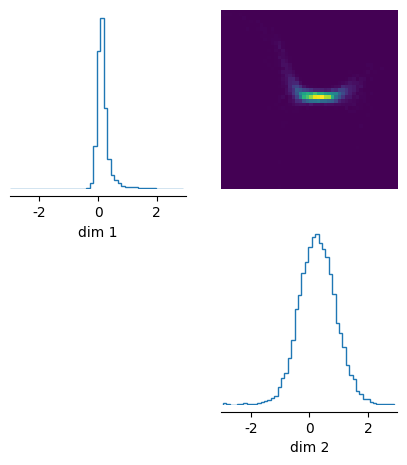

In [11]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)